# Second Order Extended Kalman Filter

Wouter Kouw, last update: 05-07-2023


In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `C:\Syndr\Wouter\Onderzoek\Projecten\tue\efe-planning\FRAI2023-nlamb`


In [2]:
using Revise
using Optim
using ForwardDiff
using ProgressMeter
using LinearAlgebra
using Distributions
using Plots
default(label="", grid=false, linewidth=3, markersize=3, margin=10Plots.pt)
include("../util.jl")

e (generic function with 1 method)

## 1D state - 1D sensor

In [3]:
# Grid over state space
N = 500
states = range(0, stop=2π, length=N)

# State covariance
S_t = 1.0

# Observation noise
R = 1e-2

0.01

In [4]:
# Observation function
g(z) = sin(z)

# Derivatives
J(z) = ForwardDiff.derivative(g, z)
H(z) = ForwardDiff.derivative(J, z)

# Curvature
κ(z) = abs(H(z))/(1+ J(z)^2)^(3/2)

κ (generic function with 1 method)

In [5]:
ambET1 = zeros(N)    
for (i,m_t) in enumerate(states)

    # Unscented transform moments
    mE, SE, CE = ET1(m_t, S_t, g, addmatrix=R)

    # Calculate ambiguity
    ambET1[i] = log(max(1e-8,SE-CE'*inv(S_t)*CE))
    
end

In [6]:
ambET2 = zeros(N)    
for (i,m_t) in enumerate(states)

    # Unscented transform moments
    mE, SE, CE = ET2(m_t, S_t, g, addmatrix=R)

    # Calculate ambiguity
    ambET2[i] = log(max(1e-8,SE-CE'*inv(S_t)*CE))
    
end

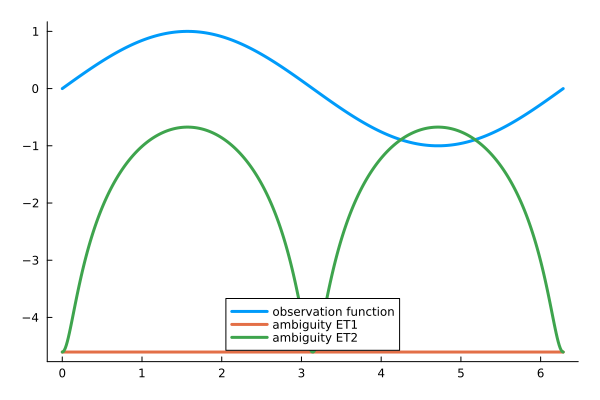

In [7]:
plot(states, g.(states), label="observation function")
plot!(states, ambET1, label="ambiguity ET1", legend=:bottom)
plot!(states, ambET2, label="ambiguity ET2", legend=:bottom)

## 2D states - 1D sensor

In [8]:
m = randn(2)
S = diagm(rand(2))

2×2 Matrix{Float64}:
 0.189867  0.0
 0.0       0.759053

In [9]:
g(x::AbstractVector) = cos(x[1]) + sin(x[2])
Jm = ForwardDiff.gradient(g, m)

2-element Vector{Float64}:
 -0.57175298300815
  0.6394315656111252

In [10]:
# Dimensionalities
N = length(g(m))
M = length(m)

Jm = ForwardDiff.gradient(g, m)

2-element Vector{Float64}:
 -0.57175298300815
  0.6394315656111252

In [11]:
Hm = ForwardDiff.hessian(g, m)
aux1 = tr(Hm*S)

-0.7393684696714606

In [12]:
aux2 = tr(Hm*S*Hm*S)

0.36484976342020076

In [13]:
μ, Σ, Γ = ET2(m,S,g)

(1.21958960212207, 0.5548488795749618, [-0.10855716399589116, 0.4853625191723033])

In [14]:
# Grid over state space
T = 100
ring = range(0, stop=2π, length=T)
states = [cos.(ring'); sin.(1/2 .*ring')]

g(x::AbstractVector) = atan(x[1],x[2])

# State covariance
S_t = diagm(ones(2))

# Observation noise
R = nothing

ambET2 = zeros(T)    
for k in 1:T

    # Unscented transform moments
    mE, SE, CE = ET2(states[:,k], S_t, g, addmatrix=R)

    # Calculate ambiguity
    ambET2[k] = 1/2*logdet(SE-CE'*inv(S_t)*CE)
    
end

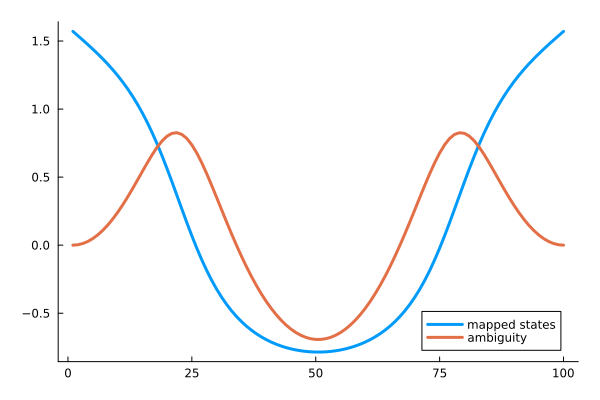

In [15]:
y = cat([g(states[:,i]) for i in 1:T]..., dims=2)
plot(y', label="mapped states")
plot!(ambET2, label="ambiguity")

## 2D states - 2D sensor

### Cartesian to polar

In [16]:
m = randn(2)
S = diagm(rand(2))

2×2 Matrix{Float64}:
 0.0125909  0.0
 0.0        0.906666

In [17]:
# Cartesian to polar
g(x::AbstractVector) = [norm(x,2), atan(x[1],x[2])]
Jm = ForwardDiff.jacobian(g, m)

2×2 Matrix{Float64}:
  0.362529  -0.931972
 -0.552037  -0.214738

In [18]:
# Dimensionalities
N = length(g(m))
M = length(m)

Jm = ForwardDiff.jacobian(g, m)

2×2 Matrix{Float64}:
  0.362529  -0.931972
 -0.552037  -0.214738

In [19]:
aux1 = zeros(eltype(m), N)
Hi = zeros(eltype(m), M,M,N)
for i in 1:N
    g_i(x) = g(x)[i]
    Hi[:,:,i] = ForwardDiff.hessian(g_i, m)
    aux1 += e(i,N)*tr(Hi[:,:,i]*S)
end
aux1

2-element Vector{Float64}:
  0.07706051184795656
 -0.2119729559566348

In [20]:
# Auxiliary terms
aux2 = zeros(eltype(m), N,N)
for i in 1:N
    for j in 1:N
        aux2 += e(i,N)*e(j,N)'*tr(Hi[:,:,i]*S*Hi[:,:,j]*S)
    end
end
aux2

2×2 Matrix{Float64}:
  0.00593832  -0.0163347
 -0.0163347    0.0477431

In [21]:
μ, Σ, Γ = ET2(m,S,g)

([1.7267722350349768, 2.6646261081141245], [0.7921293433894157 0.17076344909914756; 0.17076344909914756 0.06951697750061703], [0.004564578906230401 -0.00695066507029396; -0.8449878060263841 -0.19469527361278458])

In [22]:
# Grid over state space
T = 100
ring = range(0, stop=2π, length=T)
states = [cos.(ring'); sin.(1/2 .*ring')]

# State covariance
S_t = diagm(ones(2))

# Observation noise
R = nothing

ambET2 = zeros(T)    
for k in 1:T

    # Unscented transform moments
    mE, SE, CE = ET2(states[:,k], S_t, g, addmatrix=R, forceHermitian=true)

    # Calculate ambiguity
    ambET2[k] = 1/2*logdet(SE-CE'*inv(S_t)*CE)
    
end

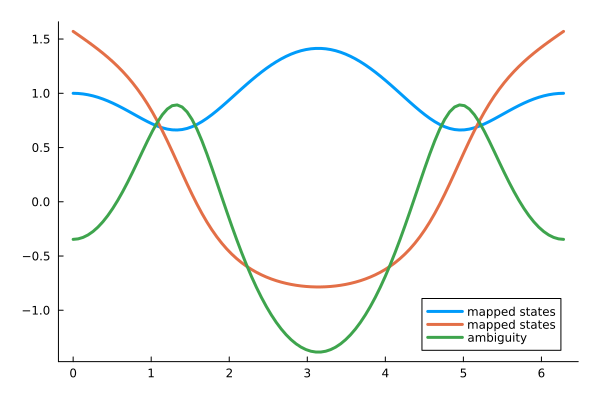

In [23]:
y = cat([g(states[:,i]) for i in 1:T]..., dims=2)
plot(ring, y', label="mapped states")
plot!(ring, ambET2, label="ambiguity")

### Polar to cartesian

In [24]:
# Cartesian to polar
g(x::AbstractVector) = [x[1]*cos(x[2]), x[1]*sin(x[2])]
Jm = ForwardDiff.jacobian(g, m)

2×2 Matrix{Float64}:
 -0.00259875   0.612035
 -0.999997    -0.00159053

In [25]:
# Dimensionalities
N = length(g(m))
M = length(m)

Jm = ForwardDiff.jacobian(g, m)

2×2 Matrix{Float64}:
 -0.00259875   0.612035
 -0.999997    -0.00159053

In [26]:
aux1 = zeros(eltype(m), N)
Hi = zeros(eltype(m), M,M,N)
for i in 1:N
    g_i(x) = g(x)[i]
    Hi[:,:,i] = ForwardDiff.hessian(g_i, m)
    aux1 += e(i,N)*tr(Hi[:,:,i]*S)
end
aux1

2-element Vector{Float64}:
 0.0014420808760007345
 0.5549109980395668

In [27]:
# Auxiliary terms
aux2 = zeros(eltype(m), N,N)
for i in 1:N
    for j in 1:N
        aux2 += e(i,N)*e(j,N)'*tr(Hi[:,:,i]*S*Hi[:,:,j]*S)
    end
end
aux2

2×2 Matrix{Float64}:
 0.0228335    0.000740893
 0.000740893  0.307926

In [28]:
μ, Σ, Γ = ET2(m,S,g)

([-0.0008694910415436278, -0.3345791138895814], [0.351041558299313 -0.00047943619803468665; -0.00047943619803468676 0.16655632808158974], [-3.272071478585328e-5 -0.012590891953813419; 0.5549109980395668 -0.0014420808760007345])

In [29]:
# Grid over state space
T = 100
states = transpose([range(0, stop=1., length=T) range(0, stop=2π, length=T)])

# State covariance
S_t = diagm(ones(2))

# Observation noise
R = nothing

ambET2 = zeros(T)    
for k in 1:T

    # Unscented transform moments
    mE, SE, CE = ET2(states[:,k], S_t, g, addmatrix=R, forceHermitian=true)

    # Calculate ambiguity
    ambET2[k] = 1/2*logdet(SE-CE'*inv(S_t)*CE)
    
end

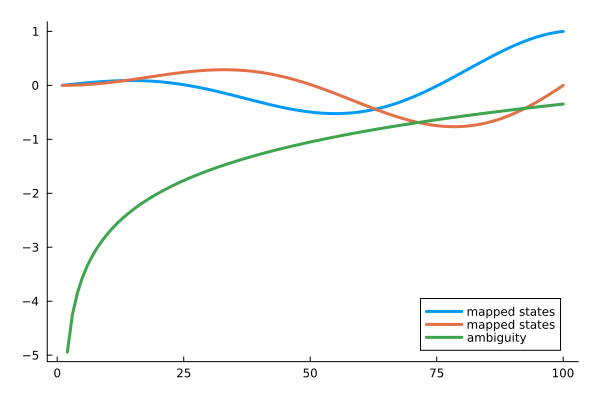

In [30]:
y = cat([g(states[:,i]) for i in 1:T]..., dims=2)
plot(y', label="mapped states")
plot!(ambET2, label="ambiguity")